# 0. Set Up

In [1]:
# Librerias
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 270 (delta 157), reused 180 (delta 75), pack-reused 0
Receiving objects: 100% (270/270), 71.11 KiB | 4.18 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43701 sha256=2c2f0a280d239c727e49564dc7d442d019ea9bc1804d3be3a7773b4b878ac434
  Stored in directory: /tmp/pip-ephem-wheel-cache-dk53fw33/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [2]:
# Numpy & Maplotlib
import numpy             as np
import matplotlib.pyplot as plt
import cv2


# Balu
from   balu3.ft.norm     import minmax
from   balu3.fx.chr      import lbp, haralick, gabor, hog, basicint, contrast, clp
from   balu3.fs.sel      import jfisher
from   balu3.fs.sel      import sfs, exsearch, clean
from   balu3.fx.geo      import basicgeo,fitellipse,hugeo,flusser,gupta
from   tqdm.auto         import tqdm
from   balu3.im.proc import im_grad,fspecial,gradlog
from   balu3.ft.trans  import pca

# Sklearn
from sklearn.metrics   import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid # KNN y DMin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

from sklearn.naive_bayes import GaussianNB  # Naive Bayer
from sklearn.base import BaseEstimator, ClassifierMixin # Bayes KDE
from sklearn.neighbors import KernelDensity

from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.linear_model import LogisticRegression # Regresion logistica
from sklearn.neural_network import MLPClassifier # NN
from sklearn.svm import SVC # SVM

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel


from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from   sklearn.model_selection import train_test_split


# 1. Image Loading

In [3]:
!wget https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
!mv jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t jaffec.zip
!unzip -qq jaffec.zip

--2024-06-18 03:14:42--  https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc23a3dbcdde45d1e8969e7f1b15.dl.dropboxusercontent.com/cd/0/inline/CVD_RFZWjnS3q8GHGN-8HCjMOIgYKPeMm8l9a2ef6H46VDQ32S8U5oPX-HPqa7BVIlzN139efNuEsJDmAn_JyHp3FFUjwgdnStR_Gzf36FoX6SVh2z6iqtH-0Jc8DsmChcg/file# [following]
--2024-06-18 03:14:42--  https://uc23a3dbcdde45d1e8969e7f1b15.dl.dropboxusercontent.com/cd/0/inline/CVD_RFZWjnS3q8GHGN-8HCjMOIgYKPeMm8l9a2ef6H46VDQ32S8U5oPX-HPqa7BVIlzN139efNuEsJDmAn_JyHp3FFUjwgdnStR_Gzf36FoX6SVh2z6iqtH-0Jc8DsmChcg/file
Resolving uc23a3dbcdde45d1e8969e7f1b15.dl.dropboxusercontent.com (uc23a3dbcdde45d1e8969e7f1b15.dl.dropboxusercontent.com)... 162.125.72.15, 2620:100:6021:15::a27d:410f
Connecting to uc23

In [4]:
def num2fixstr(x: int, d: int) -> str:
    """
    Transforma en un string un numero x en una cantidad de x digitos
    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    """
    Retorna la ruta de la imagen a cargar dada una clase num_class y un
    identificador de imagen num_img
    """

    FPATH = 'jaffec'
    PREFIX = 'face'
    img_class = num2fixstr(num_class, 3)
    img_num = num2fixstr(num_img, 5)
    img_path = f'{FPATH}/{PREFIX}_{img_class}_{img_num}.png'

    return img_path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Carga la imagen
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
        print(f'loading image {path} ...')
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    return img

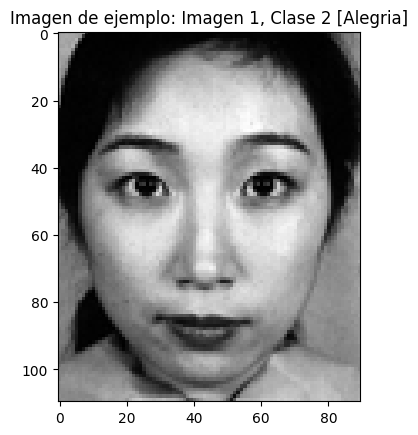

In [5]:
test_img = imageload(1,1)
plt.title('Imagen de ejemplo: Imagen 1, Clase 1 [Alegria]')
plt.imshow(test_img, cmap='gray')
plt.show()

# 2. Image Preprocessing [TODO]

👉🏻 Aplicamos el clasificador Haar Cascade preentrenado para detectar el perfil frontal de la cara de una persona.
👉🏻 Luego, aplicamos este clasificador sobre la imagen con los siguientes parametros:
* `scaleFactor = 1.1`: reducimos la imagen en un 10% de su tamaño original
* `minNeighbors = 5`: especifica el numero de rectangulos vecinos que necesita el clasificador para que un objeto se considere valido
* `minSize= (40,40)`: tamaño minimo del objeto a aser detectado.

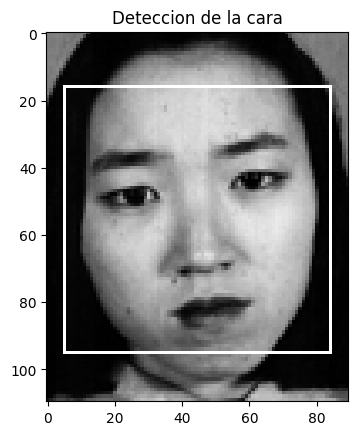

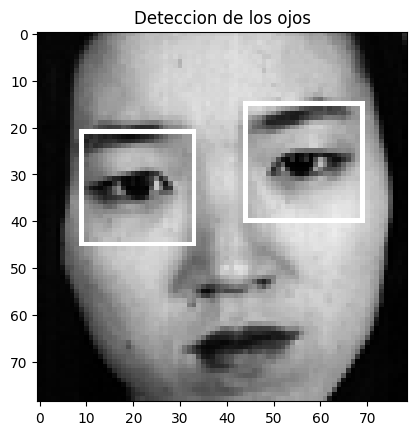

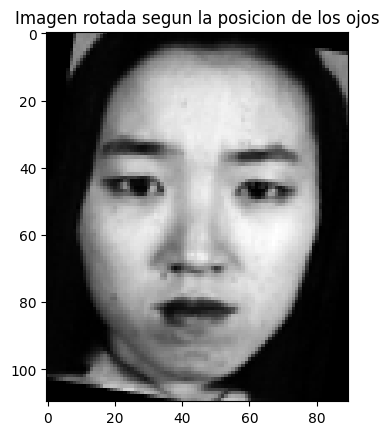

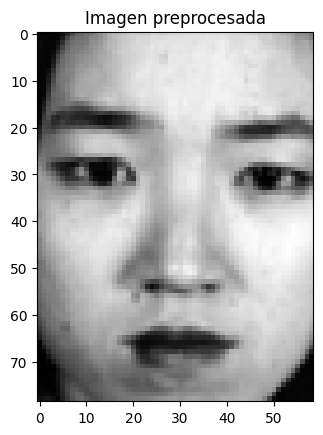

In [204]:
def eyes_detection(face, show=False):
  eyes_classifier = cv2.CascadeClassifier(
      cv2.data.haarcascades + "haarcascade_eye.xml"
  )
  eyes = eyes_classifier.detectMultiScale(
      face, scaleFactor=1.1, minNeighbors=1
  )
  index = 0

  face2show = np.copy(face)
  for (ex , ey,  ew,  eh) in eyes:
    if index == 0:
      eye_1 = (ex, ey, ew, eh)
    elif index == 1:
      eye_2 = (ex, ey, ew, eh)
    cv2.rectangle(face2show, (ex,ey) ,(ex+ew, ey+eh), (255,255,255), 1)
    index = index + 1
  if show:
    plt.imshow(face2show, cmap='gray')
    plt.title('Deteccion de los ojos')
    plt.show()

  if eye_1[0] < eye_2[0]:
    left_eye = eye_1
    right_eye = eye_2
  else:
    left_eye = eye_2
    right_eye = eye_1

  return left_eye, right_eye

def get_eyes_position(left_eye, right_eye):
  # Calculamos el punto central del ojo izquierdo
  left_eye_center = (
      int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2))
      )
  left_eye_x, left_eye_y = left_eye_center[0], left_eye_center[1]
  # Calculamos el punto central del ojo derecho (pupila)
  right_eye_center = (
      int(right_eye[0] + (right_eye[2] / 2)), int(right_eye[1] + (right_eye[3] / 2))
      )
  right_eye_x, right_eye_y = right_eye_center[0], right_eye_center[1]

  return (left_eye_x, left_eye_y), (right_eye_x, right_eye_y)


def face_align(img, left_eye, right_eye, show=False):
  # Calculamos el punto central del ojo izquierdo y derecho (pupilas)
  left_eye_pos, right_eye_pos = get_eyes_position(left_eye, right_eye)
  left_eye_x, left_eye_y = left_eye_pos
  right_eye_x, right_eye_y = right_eye_pos
  # Ahora, utilizando la ubicacion de cada pupila de los ojos, buscamos
  # la recta "A" que une ambos puntos para posteriormente calcular el angulo
  # de rotacion
  if left_eye_y > right_eye_y:
    line_between_eyes = (right_eye_x, left_eye_y)
    rot_direction = -1 # el -1 indica que la imagen sera rotada en la direccion horaria
  else:
    line_between_eyes = (left_eye_x, right_eye_y)
    rot_direction = 1 # el 1 indica que la imagen sera rotada en la direccion antihoraria

  # Calculamos el angulo de rotacion entre la linea que separa ambos ojos
  delta_x = right_eye_x - left_eye_x
  delta_y = right_eye_y - left_eye_y
  angle = np.arctan(delta_y / delta_x)
  angle = (angle * 180) / np.pi

  height, width = img.shape[:2] # Alto y ancho de la imagen
  center_img = (width // 2, height // 2) # Centro de la imagen
  rot_matrix = cv2.getRotationMatrix2D(center_img, (angle), 1.0) # definimos la matriz de rotacion
  # aplicamos la rotacion sobre la imagen
  face_rotated = cv2.warpAffine(img, rot_matrix, (width, height))

  if show:
    plt.title('Imagen rotada segun la posicion de los ojos')
    plt.imshow(face_rotated, cmap='gray')
    plt.show()

  return face_rotated

def face_detection(img, show=False):
  face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
  )
  face = face_classifier.detectMultiScale(
    img, scaleFactor=1.005, minNeighbors=5, minSize=(20, 20)
  )
  x, y, width, height = face[0]
  face_cropped = img[y:(y + height), x:(x + width)]

  if show:
    # Mostramos el resultado de la deteccion de la cara
    img2show = np.copy(img)
    plt.title('Deteccion de la cara')
    cv2.rectangle(img2show, (x, y), (x + width, y + height), (255, 255, 255), 1)
    plt.imshow(img2show, cmap='gray')
    plt.show()

  return face_cropped, (x, y, width, height)


def reshape(img, left_eye, right_eye):
  # Restaremos 8 pixeles de diferencia hacia la izquierda desde el ojo izquierdo
  # y hacia la derecha del ojo derecho
  left_eye_pos, right_eye_pos = get_eyes_position(left_eye, right_eye)
  left_eye_pos_x, _ = left_eye_pos
  right_eye_pos_x, _ = right_eye_pos
  height, width = img.shape
  NOISE = 12 # determinamos un ruido de 10 pixeles, entre mas grande el valor,
  # mas ruido integramos a la imagen
  x_start = left_eye_pos_x - NOISE
  x_end = right_eye_pos_x + NOISE
  #reshaped_img = img[:, max(left_eye_pos_x - NOISE, 0):min(right_eye_pos_x + NOISE, width)]
  reshaped_img = img[:, x_start:x_end]

  return reshaped_img


def preprocess(img):
  # Primero detectamos la cara de la persona
  face, (x, y, width, height) = face_detection(img, show=True)
  # Luego detectamos los ojos
  left_eye, right_eye = eyes_detection(face, show=True)
  # Y por ultimo, rotamos la imagen si es que la cara se encuentra rotada.
  face_aligned = face_align(img, left_eye, right_eye, show=True)
  # Realizamos el recorte de la foto
  face_cropped = face_aligned[y:(y + height), x:(x + width)]
  # Realizamos un reajuste del ancho para eliminar ruido (como el pelo)
  face_reshaped = reshape(face_cropped, left_eye, right_eye)
  #return face_cropped
  return face_reshaped




test_img_2 = imageload(5,22)
#test_img_2 = imageload(4,15)

#test_img_2 = imageload(4, 28)
#test_img_2 = imageload(5,12)
#test_img_2 = imageload(5,25)
#test_img_2 = imageload(6,22)
#test_img_2 = imageload(6, 9)
#test_img_2 = imageload(5, 4)
#test_img_2 = imageload(6, 24)
#test_img = imageload(5, 20)

preprocessed_img = preprocess(test_img_2)
plt.title('Imagen preprocesada')

plt.imshow(preprocessed_img, cmap='gray')
plt.show()

# 3. Feature Extraction


In [ ]:
K = 7 # Cantidad de clases del dataset
N = 30 # Cantidad de imagenes por clase
y = np.zeros((K * N), 'int') # Vector de clasificacion


# ------------------------------- LBP ------------------------------------------
hdiv_0 = 1 # LBP con 8x8 particiones
vdiv_0 = 1
Mlbp = 10 * hdiv_0 * vdiv_0 # Numero de elementos vector LBP
Xlbp = np.zeros((K * N, Mlbp)) # Matriz de caracteristicas para descriptor LBP


# ----------------------------- HARALICK ---------------------------------------
Mhar = 24 # Numero de elmeentos vector Haralick para distancia = 1
Xhar = np.zeros((K * N, Mhar)) # Matriz de caracteristicas de Haralick
d_0 = 1 # Parametro de distancia

# ------------------------------- Hog ------------------------------------------
hog_orientations = 9
px_0 = 64 # Parametro pixeles por bloque: 64 pixeles por bloque
cl_0 = 1 # Parametro celdas por bloque: 2 celdas por bloque
bn = 9 # Numero de bins del descriptor Hog.
Mhog = 9 # Numero de elementos en total del vector descriptor
Xhog = np.zeros((K * N, Mhog)) # Matriz  de caracteristicas para descriptor Hog


# ------------------------------- Gabor ----------------------------------------
rotations_0 = 8 # 8 rotaciones
dilations_0 = 8 # 8 escalas
Mgab = rotations_0 * dilations_0 + 3 # Numero de elementos vector de Gabor para 8 rotaciones y escalas
Xgab = np.zeros((K * N, Mgab))


In [ ]:

t = 0
# sc: Selected Channel (SC)
# Inicializamos una matriz de caracteristicas para cada canal.
Xlbp = np.zeros((K * N, Mlbp))
Xhar = np.zeros((K * N, Mhar))
Xhog = np.zeros((K * N, Mhog))
Xgab = np.zeros((K * N, Mgab))

print(f' Extracting features ... '.center(100, '*'))

for k in range(K): # Por cada clase ...
    print(f'Extracting features: batch {k + 1}/7')

    for i in tqdm(range(N)): # Por cada imagen ...
        num_class = k + 1
        num_img = i + 1
        # Cargamos la i-esima imagen de la k-esima clase
        img = 255*imageload(num_class, num_img)
        # Preprocesamos la imagen para eliminar ruido y resaltar el lunar

        # LBP con 1x1 particiones
        Xlbp[t,:] = lbp(img, hdiv=hdiv_0, vdiv=vdiv_0,
                            mapping='uniform', norm=True)

        # Haralick con d=1 pixeles
        Xhar[t,:] = haralick(img, distance=d_0)

        # Hog con 9 orientaciones
        Xhog[t,:] = hog(img, orientations=hog_orientations,
                            cells_per_block=(cl_0, cl_0),
                            pixels_per_cell=(px_0, px_0),
                            norm=False)
        # Gabor
        Xgab[t,:] = gabor(img,
                              dilations=dilations_0,
                              rotations=rotations_0)

        # Vector de clasificacion
        y[t] = k + 1 # Deberia ser el mismo para los 3 canales.
        t = t + 1

************************************* Extracting features ... **************************************
Extracting features: batch 1/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 2/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 3/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 4/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 5/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 6/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 7/7


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
X = np.concatenate((Xlbp, Xhar, Xhog, Xgab), axis=1)

# 4. Leave One Person Out

In [ ]:
def split_train_test_val(X, y, i):
  """
  Input: Matriz de caracteristicas X y vector de clases y
  Output: Conjuntos training, testing y validation.
  """
  # i: i-esima mujer
  W = 10
  K = np.max(y) # Cantidad de clases = 7
  N = X.shape[0] // K # Numero de muestras por clase = 30
  N_test = (N // W) * K # numero de muestras de testing = 21
  N_val = (N // W) * K # numero de muestras de validation
  N_train = (N * K) - (N_test + N_val) # numero de muestras de training

  M = X.shape[1]  # Cantidad de caracteristicas

  # Matrices de caracteristicas para Training, testing y Validation.
  Xtrain = np.zeros((N_train, M))
  ytrain = np.zeros((N_train), 'int')

  Xtest = np.zeros((N_test, M))
  ytest = np.zeros((N_test), 'int')

  Xval = np.zeros((N_val, M))
  yval = np.zeros((N_val), 'int')


  t = 0
  itrain = 0
  itest = 0
  ival = 0

  test_start_idx = i * 3
  test_end_idx = test_start_idx + 2
  val_start_idx = ((i + 1) % W) * 3
  val_end_idx = val_start_idx + 2

  for k in range(0, K): # Por cada clase
    for n in range(0, N): # Por cada muestra
      # Testing -> Mujer i
      # Ejemplo: MujerTest = 0, entonces son las imagenes 0 hasta 2
      if test_start_idx <= n <= test_end_idx:
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest += 1
      # Validation -> Mujer i+1 % 10
      # Ejemplo: MujerVal = 1, entonces son las imagenes 3 hasta 5
      elif val_start_idx <= n <= val_end_idx:
        Xval[ival,:] = X[t,:]
        yval[ival] = y[t]
        ival +=1
      # Training -> Mujeres que no sean ni Mujer test o Mujer validation
      # Ejemplo: MujeresTrain = 2..9, entonces son las imagenes 6 hasta la 29
      else:
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain += 1

      t += 1

  return Xtrain, ytrain, Xtest, ytest, Xval, yval


In [ ]:
def clean_and_normalize(Xtrain, Xtest, Xval):
  # aplicamos Clean para eliminar las columnas redundantes y evitar nulos
  sclean = clean(Xtrain)
  Xtrain_clean = Xtrain[:, sclean]
  Xtest_clean = Xtest[:, sclean]
  Xval_clean = Xval[:, sclean]
  # aplicamos normalizacion sobre training, y luego escalamos testing y validation.
  Xtrain_norm, a, b = minmax(Xtrain_clean)
  Xtest_norm = Xtest_clean * a + b
  Xval_norm = Xval_clean * a + b
  return Xtrain_norm, Xtest_norm, Xval_norm

In [ ]:
class sfsbalu():
  def __init__(self, p, show=0):
    self.p = p
    self.show = show
  def fit(self,X,y):
    self.sel = sfs(X,y,self.p,show=self.show)
    self.m   = X.shape[1]
  def get_support(self):
    s = np.zeros((self.m,))
    s[self.sel] = 1
    return s
  def __repr__(self):
    return f"SFS = {self.sel}"

g = [
      sfsbalu(p=3),
      sfsbalu(p=4),
      sfsbalu(p=5),
      #SelectFromModel(RandomForestClassifier(n_estimators=50), max_features=3),
      #SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=3),
      #SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=4),
      #SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=5),
      #SelectFromModel(RandomForestClassifier(n_estimators=50), max_features=6),
      #SelectFromModel(LogisticRegression(penalty="l2"), max_features=6)
     ]

In [ ]:
# --------------------------------- KNN ------------------------------------
n_neighbors = list(range(1,30))
knns = [KNeighborsClassifier(n_neighbors = n) for n in n_neighbors]

# --------------------------------- SVM ------------------------------------
kernels = ["rbf"]
gammas = [0.05, 0.1, 1, 10]
cs = [0.01, 0.1, 1, 10, 100]
degrees = [2, 5, 10, 15]
svms = []
for kernel in kernels:
  if kernel != 'linear':
    for c in cs:
      for gamma in gammas:
        if kernel == "poly":
          for degree in degrees:
            svms.append(SVC(kernel = kernel, C = c, gamma = gamma, degree = degree))
        else:
          svms.append(SVC(kernel = kernel, C = c, gamma = gamma))
  else:
    svms.append(SVC(kernel = kernel))
# ---------------------------- Random Foret --------------------------------
n_estimators = list(range(100, 300, 100))
depth = list(range(10, 30, 10))
random_forests = [RandomForestClassifier(n_estimators=n, max_depth=d) for d in depth for n in n_estimators]

# ---------------------------------- NN ------------------------------------
solvers = ['sgd', 'adam']
learning_rates = [round(j * (10) **(-i), 5) for i in range(1, 4) for j in range(1, 3)]

hidden_layers = [i for i in range(5, 20, 5)]
hidden_layers += [(i, j) for i in range(25, 110, 50) for j in range(25, 110, 50)]
#neuronal_networks = list(set(MLPClassifier(solver = solver, hidden_layer_sizes=hidden_layer, learning_rate_init=learning_rate)
#                        for solver in solvers
#                        for hidden_layer in hidden_layers
#                        for learning_rate in learning_rates))
neuronal_networks = [
    MLPClassifier(hidden_layer_sizes=5, learning_rate_init=0.1, solver='sgd'),
    MLPClassifier(hidden_layer_sizes=15, learning_rate_init=0.02),
    MLPClassifier(hidden_layer_sizes=(75, 75), learning_rate_init=0.002),
    MLPClassifier(hidden_layer_sizes=(75, 75), learning_rate_init=0.01, solver='sgd'),
    MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate_init=0.02),
    MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate_init=0.02, solver='sgd')
]

# Diccionario de modelos
h = {
    'knn' : knns,
    'svm' : svms,
    'rfs' : random_forests,
    'NN'  : neuronal_networks,
}

In [ ]:
# Funcion evaluacion
def holdout(clf, Xtrain, ytrain, Xtest, ytest):
  clf.fit(Xtrain, ytrain)
  ypred  = clf.predict(Xtest)
  acc = accuracy_score(ytest, ypred)
  return acc


In [ ]:
def find_best_model(g, h, clf_type, Xtrain, ytrain, Xval, yval):
    # Buscamos las mejores columnas
    nsel = 5
    n = len(g)
    q = len(h[clf_type])
    max_acc = 0
    id_best_g = -1 # Mejor funcion selectora/transformadora
    id_best_h = -1 # Mejor clasificador

    #for i in range(0, n): # por cada funcion selectora/transformadora de caracts.
        #model = g[i]
        #model.fit(Xtrain, ytrain)
        #sel = np.nonzero(model.get_support())[0]
        #Xtrain_sel = Xtrain[:, sel]
        #Xval_sel = Xval[:, sel]

    for k in range(0, q):
      clf = h[clf_type][k] # k-esimo Clasificador 'model'
      #acc = holdout(clf, Xtrain_sel, ytrain, Xval_sel, yval)
      acc = holdout(clf, Xtrain, ytrain, Xval, yval)
      if acc > max_acc:
        max_acc = acc
        #id_best_g = i
        id_best_h = k
    print('   - accVal: ', max_acc)
    return id_best_g, id_best_h


In [ ]:
def leave_one_out(clf_type, X, y):
  accuracies = []

  for i in range(0, 10):
    print(f'Mujer testing {i}')
    # 1. Realizamos Split sets training, testing y de validacion
    Xtrain, ytrain, Xtest, ytest, Xval, yval = split_train_test_val(X, y, i)

    # 2. Aplicamos Clean y Normalizacion
    Xtrain_norm, Xtest_norm, Xval_norm = clean_and_normalize(Xtrain, Xtest, Xval)

    # 3. Select best model: Feature Selection and Transformation
    #    Buscamos los mejores hiperparametros para elegir la mejor combinacion de
    #    selector/transformador y clasificador.
    id_best_g, id_best_h = find_best_model(g, h, clf_type, Xtrain_norm, ytrain, Xval_norm, yval)

    # 4. Aplicamos la mejor seleccion/transformacion de caractersticas
    #best_g = g[id_best_g]
    #print(f'  - Mejor seleccion = {best_g}')
    #best_g.fit(Xtrain_norm, ytrain)
    #sel = np.nonzero(best_g.get_support())[0]

    #Xtrain_sel = Xtrain_norm[:, sel]
    #Xtest_sel = Xtest_norm[:, sel]

    # 5. Aplicamos el mejor clasificador en testing y obtenemos el accuracy
    best_h = h[clf_type][id_best_h]
    print(f'  - Mejor modelo = {best_h}')
    #accuracy = holdout(best_h, Xtrain_sel, ytrain, Xtest_sel, ytest)
    accuracy = holdout(best_h, Xtrain_norm, ytrain, Xtest_norm, ytest)
    print('   - accTest: ', accuracy)
    accuracies.append(accuracy)

  acc = np.mean(accuracies)
  std = np.std(accuracies)
  acc_st = "{:.2f} +/- {:.2f}".format(acc*100,std*100)
  print('Accuracy (CV'+str(10)+')= '+str(acc_st))

leave_one_out('knn', X, y)



Mujer testing 0
   - accVal:  0.2857142857142857
  - Mejor modelo = KNeighborsClassifier(n_neighbors=4)
   - accTest:  0.23809523809523808
Mujer testing 1
   - accVal:  0.38095238095238093
  - Mejor modelo = KNeighborsClassifier(n_neighbors=3)
   - accTest:  0.2857142857142857
Mujer testing 2
   - accVal:  0.19047619047619047
  - Mejor modelo = KNeighborsClassifier(n_neighbors=13)
   - accTest:  0.14285714285714285
Mujer testing 3
   - accVal:  0.38095238095238093
  - Mejor modelo = KNeighborsClassifier(n_neighbors=25)
   - accTest:  0.14285714285714285
Mujer testing 4
   - accVal:  0.3333333333333333
  - Mejor modelo = KNeighborsClassifier(n_neighbors=1)
   - accTest:  0.38095238095238093
Mujer testing 5
   - accVal:  0.42857142857142855
  - Mejor modelo = KNeighborsClassifier(n_neighbors=6)
   - accTest:  0.09523809523809523
Mujer testing 6
   - accVal:  0.23809523809523808
  - Mejor modelo = KNeighborsClassifier(n_neighbors=1)
   - accTest:  0.23809523809523808
Mujer testing 7
   - 